
Calibrated LightGBM Results at Precision ≥ 0.6 (if possible):
Best threshold: 0.92
F1 Score:       0.042
Precision:      0.602
Recall:         0.022
ROC AUC:        0.630
Avg Precision:  0.206


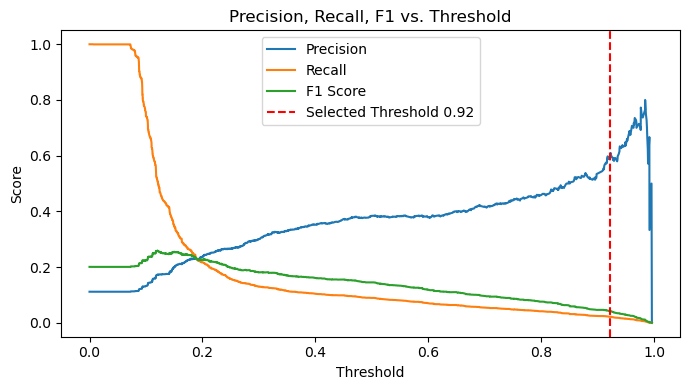

['threshold.pkl']

In [1]:
# ========== Libraries ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
import joblib  # ✅ added

# ========== Data Load & Initial Cleaning ==========
df = pd.read_csv(r"C:\Users\tiwar\OneDrive\Desktop\Health informatics\Projects\archive\diabetic_data.csv")
df.replace('?', np.nan, inplace=True)
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True, errors='ignore')
df = df[df['gender'] != 'Unknown/Invalid']

# ========== Target variable ==========
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df.drop('readmitted', axis=1, inplace=True)

# ========== Remove sparse columns ==========
missing_ratio = df.isna().sum() / len(df)
df.drop(columns=missing_ratio[missing_ratio > 0.5].index.tolist(), inplace=True)
df.drop(columns=['weight', 'payer_code'], errors='ignore', inplace=True)
df = df.reset_index(drop=True)
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# ========== Feature Engineering ==========
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
           '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
df['age_numeric'] = df['age'].map(age_map)
df.drop('age', axis=1, inplace=True)

med_cols = [c for c in [
    'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'insulin', 'repaglinide', 
    'nateglinide', 'chlorpropamide', 'acarbose', 'miglitol', 'troglitazone', 
    'tolazamide', 'tolbutamide', 'acetohexamide', 'glimepiride', 'glipizide-metformin', 
    'glyburide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
] if c in df.columns]
id_cols = [c for c in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'] if c in df.columns]
le = LabelEncoder()
for col in med_cols + id_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Group diagnoses
def group_diag(code):
    if pd.isna(code): return 'Other'
    try: code = float(code)
    except: return 'Other'
    if (390 <= code < 460) or (code == 785): return 'Circulatory'
    elif (460 <= code < 520) or (code == 786): return 'Respiratory'
    elif (520 <= code < 580) or (code == 787): return 'Digestive'
    elif (250 <= code < 251): return 'Diabetes'
    elif (800 <= code < 1000): return 'Injury'
    elif (710 <= code < 740): return 'Musculoskeletal'
    elif (580 <= code < 630) or (code == 788): return 'Genitourinary'
    elif (140 <= code < 240): return 'Neoplasms'
    else: return 'Other'
for c in ['diag_1', 'diag_2', 'diag_3']:
    if c in df.columns:
        df[c] = df[c].apply(group_diag)
df = pd.get_dummies(df, columns=['diag_1', 'diag_2', 'diag_3'], prefix=['D1', 'D2', 'D3'], drop_first=True)

# Key engineered features
df['total_visits'] = df.get('number_outpatient', 0) + df.get('number_emergency', 0) + df.get('number_inpatient', 0)
df['long_stay'] = (df['time_in_hospital'] > 7).astype(int)
diag_cats = [col for col in df.columns if col.startswith('D1_')]
df['num_comorbidities'] = df[diag_cats].sum(axis=1)
df['has_insulin'] = df['insulin'] if 'insulin' in df.columns else 0
df['medication_count'] = df[med_cols].astype(int).sum(axis=1)
df['high_risk_discharge'] = df['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21]).astype(int)
if 'max_glu_serum' in df.columns:
    df['abnormal_glucose'] = df['max_glu_serum'].isin(['>200', '>300']).astype(int)
if 'A1Cresult' in df.columns:
    df['abnormal_A1C'] = df['A1Cresult'].isin(['>7', '>8']).astype(int)

# Remove rare object categories
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() > 10:
        rare = df[col].value_counts()[df[col].value_counts() < 50].index
        df[col] = df[col].replace(rare, 'Other')
df = pd.get_dummies(df, drop_first=True)

# Top feature interactions
if 'age_numeric' in df.columns and 'total_visits' in df.columns:
    df['ageXvisits'] = df['age_numeric'] * df['total_visits']
if 'num_comorbidities' in df.columns and 'medication_count' in df.columns:
    df['comorbXmed'] = df['num_comorbidities'] * df['medication_count']

# ========== Feature Selection ==========
X = df.drop(columns=['readmitted_binary'])
y = df['readmitted_binary']

# Remove highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.93)]
X = X.drop(columns=to_drop)

# Keep top 30 features (mutual info)
selector = SelectKBest(mutual_info_classif, k=min(30, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X = X[selected_features]

# ========== Train/Test split ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========== Scaling ==========
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Save scaler and feature order
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selected_features.tolist(), "selected_features.pkl")
joblib.dump(X_train.columns.tolist(), "scaler_features.pkl")

# ========== Imbalanced Sampling ==========
sampler = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = sampler.fit_resample(X_train_scaled, y_train)

# ========== Model Definition ==========
base_model = LGBMClassifier(
    n_estimators=250,
    max_depth=10,
    scale_pos_weight=(y_train_bal == 0).sum() / (y_train_bal == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# ========== Probability Calibration ==========
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=3)
calibrated_model.fit(X_train_bal, y_train_bal)

# ========== Threshold Tuning (Precision ≥ 0.6) ==========
y_proba = calibrated_model.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1s = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)

target_prec = 0.6
ix = np.where(precisions[:-1] >= target_prec)[0]
if len(ix) > 0:
    best_ix = ix[np.argmax(recalls[:-1][ix])]
    best_threshold = thresholds[best_ix]
else:
    best_ix = np.argmax(f1s)
    best_threshold = thresholds[best_ix]

y_pred = (y_proba >= best_threshold).astype(int)

# ========== Final Evaluation ==========
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

print(f"\nCalibrated LightGBM Results at Precision ≥ 0.6 (if possible):")
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 Score:       {f1:.3f}")
print(f"Precision:      {prec:.3f}")
print(f"Recall:         {rec:.3f}")
print(f"ROC AUC:        {auc:.3f}")
print(f"Avg Precision:  {ap:.3f}")

plt.figure(figsize=(7, 4))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Selected Threshold {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs. Threshold")
plt.legend()
plt.tight_layout()
plt.show()

# ========== Save Artifacts ==========
joblib.dump(calibrated_model, "lgbm_model.pkl")
joblib.dump(best_threshold, "threshold.pkl")
